In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds


from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

In [3]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)

In [4]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(32, activation='relu', name='hidden-layer-2'),
    tf.keras.layers.Dense(16, activation='relu', name='hidden-layer-3'),
    tf.keras.layers.Dense(1, name='output-layer')
])

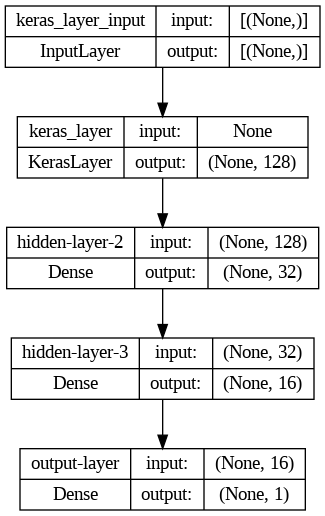

In [5]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 hidden-layer-2 (Dense)      (None, 32)                4128      
                                                                 
 hidden-layer-3 (Dense)      (None, 16)                528       
                                                                 
 output-layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 124647361 (475.49 MB)
Trainable params: 124647361 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=5,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/5
30/30 [==============================] - 16s 197ms/step - loss: 1.0303 - accuracy: 0.5699 - val_loss: 0.6167 - val_accuracy: 0.6792
Epoch 2/5
30/30 [==============================] - 6s 187ms/step - loss: 0.4651 - accuracy: 0.7928 - val_loss: 0.4297 - val_accuracy: 0.8207
Epoch 3/5
30/30 [==============================] - 5s 159ms/step - loss: 0.2492 - accuracy: 0.9080 - val_loss: 0.4072 - val_accuracy: 0.8752
Epoch 4/5
30/30 [==============================] - 5s 175ms/step - loss: 0.1368 - accuracy: 0.9584 - val_loss: 0.4478 - val_accuracy: 0.8885
Epoch 5/5
30/30 [==============================] - 5s 152ms/step - loss: 0.0838 - accuracy: 0.9795 - val_loss: 0.5347 - val_accuracy: 0.8863


In [9]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 3s - loss: 0.6125 - accuracy: 0.8652 - 3s/epoch - 58ms/step
loss: 0.612
accuracy: 0.865


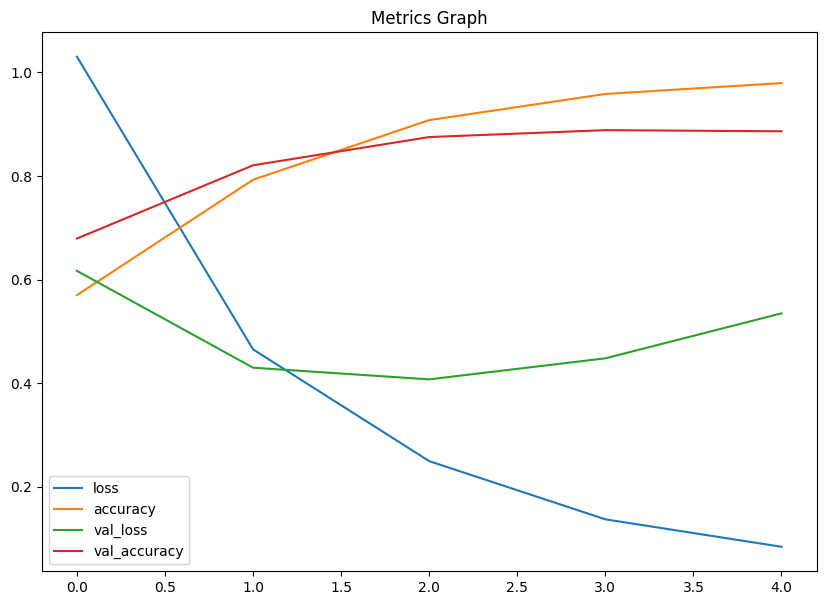

In [10]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.title("Metrics Graph")
plt.show()

In [11]:
texts = []
true_labels = []
for text, label in test_data:
    texts.append(text.numpy())
    true_labels.append(label.numpy())
texts = np.array(texts)
true_labels = np.array(true_labels)

In [12]:
predicted_probs = model.predict(texts)

782/782 [==============================] - 6s 7ms/step


In [13]:
predicted_labels = (predicted_probs > 0.5).astype(int)

In [14]:
report = metrics.classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.83      0.92      0.87     12500
    Positive       0.91      0.81      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.86     25000
weighted avg       0.87      0.87      0.86     25000



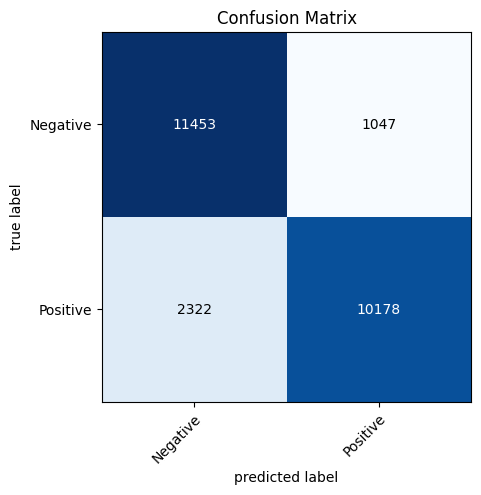

In [15]:
cm = metrics.confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(cm, class_names=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.show()